In [ ]:
#basic libary
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import rand as sprand
from pathlib import Path
import math
from sklearn.metrics import mean_squared_error
from google.colab import drive

#Ingest and process Data

To start the algorithms first we need to ingest the data and clean it for the algorithms. 

In this part we read the .txt file of Netflix Rating from https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data?resource=download and convert it into a pandas dataframe with 3 columns: user_id - movie_id - rating - timestamp


In [ ]:
# Mount google drive to get the files
drive.mount('/content/drive/')
path = "/content/drive/MyDrive/DeepLearning/archive/combined_data_2.txt"
qualifying_path = "/content/drive/MyDrive/DeepLearning/archive/qualifying.txt"

Mounted at /content/drive/


In [ ]:
# Read the text file into csv
df = pd.read_csv(path, sep=',', names=['user_id', 'rating', 'timestamp'])
q_df = pd.read_csv(qualifying_path, sep=',', names=['user_id', 'timestamp'])

Since the txt file's format is a movie ID followed by lines of user ID, rating and timestamp, separated with a comma, we need to read each line to find the movie IDs and create a column for them. 

In [ ]:
# ---------------------------------Making the Movies column for the training data----------------
movies_list = []
movie_index = df.loc[pd.isna(df["rating"]), :].index.tolist() # Gets the indexes of the lines containing movie_id
for i in range (len(movie_index) - 1):
  movies_list += [df.iloc[movie_index[i]]['user_id'].strip(':')]* ((int(movie_index[i+1]) - int(movie_index[i])-1)) # Adds a movie_id for each user and rating

movies_list += [df.iloc[movie_index[-1]]['user_id'].strip(':')]*((len(df) - int(movie_index[-1]))-1)

df = df.dropna() # Erasing the lines containing only movie_id
df['movie_id'] = movies_list # Add the movie_id column to the dataset

# ---------------------------------Making the Movies column for the test data------------------
movies_list = []
movie_index = q_df.loc[pd.isna(q_df["timestamp"]), :].index.tolist()
for i in range (len(movie_index) - 1):
  movies_list += [q_df.iloc[movie_index[i]]['user_id'].strip(':')]* ((int(movie_index[i+1]) - int(movie_index[i])-1))

movies_list += [q_df.iloc[movie_index[-1]]['user_id'].strip(':')]*((len(q_df) - int(movie_index[-1]))-1)

q_df = q_df.dropna()
q_df['movie_id'] = movies_list

<ipython-input-11-c06c9e47019f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_df['movie_id'] = movies_list


In [ ]:
# Cutting df 10 times in half for the notebook not to crash!
print(len(df))
for i in range(10):
  df = df[0:math.ceil(len(df)/2)]
  print(len(df))
q_df = q_df[q_df['user_id'].isin(df['user_id']) & q_df['movie_id'].isin(df['movie_id'])]

26977591
13488796
6744398
3372199
1686100
843050
421525
210763
105382
52691
26346


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'],format= '%Y-%M-%d' )
time_80 = np.quantile(df.timestamp.values, 0.8) # Slicing 20% for the validation Dataset
train = df[df['timestamp'] < time_80].copy()
validation = df[df['timestamp'] >= time_80].copy()
train.reset_index()
validation.reset_index()
q_df.reset_index()

,index,user_id,timestamp,movie_id
0,1868088,1429631,2005-08-02,4501
1,1868095,521749,2005-09-08,4501
2,1868101,230810,2005-12-08,4501
3,1868105,917831,2005-07-14,4501
4,1868139,270522,2005-04-25,4503
5,1868143,774423,2005-09-20,4503
6,1868154,1390282,2005-10-10,4504
7,1868169,818290,2005-12-19,4505
8,1868188,108360,2005-11-21,4505
9,1868201,1555156,2005-10-12,4505


In Pytorch we need to have the IDs from 0 to the number of users-1. 

But our IDs do not start from 0 to the number of users, so we need to map them between them in the following cells.


In [ ]:
# -----------------------------------TRAINING SET-------------------------------
# encoding user ids and movie ids with continous ids as Pytorch requires
train_user_id = np.sort(np.unique(train.user_id.values))
num_users = len(train_user_id)

train_movie_id = np.sort(np.unique(train.movie_id.values))
num_movies = len(train_movie_id)

# map the user IDs between 0 to length of users in training set
userid2idx = {o:i for i,o in enumerate(train_user_id)}

train['user_id'] = train['user_id'].apply(lambda x:userid2idx[x])
validation['user_id'] = validation['user_id'].apply(lambda x:userid2idx.get(x, -1)) # -1 for users not in training
validation = validation[validation['user_id'] >= 0].copy() # getting rid of users that were not in training 
q_df['user_id'] = q_df['user_id'].apply(lambda x:userid2idx.get(x, -1)) # -1 for users not in training
q_df = q_df[q_df['user_id'] >= 0].copy()

# doing the same steps for movies IDs
movieid2idx = {o:i for i,o in enumerate(train_movie_id)}

train['movie_id'] = train['movie_id'].apply(lambda x:movieid2idx[x])
validation['movie_id'] = validation['movie_id'].apply(lambda x:movieid2idx.get(x, -1))
validation = validation[validation['movie_id'] >= 0].copy()
q_df['movie_id'] = q_df['movie_id'].apply(lambda x:movieid2idx.get(x, -1))
q_df = q_df[q_df['movie_id'] >= 0].copy()

#Matrix Factorization Model Creation 

In the following we train a matrix factorization model to solve the Matrix Completion problem. The description of the theory of matrix factorization is mentioned in the project report but to understand the following steps we will give a definition of it in a nutshell:

The Matrix Factorization algorithm, generates two different matrices containing the latent factors based on one main matrix. The goal is to improve the latent factors (or features) untill we have a model with acceptable precision. 

In the following model, the "Embedding" function from torch library creates vectors of random encodes for our users and items and optimized them each time that we run the model. This step is called the "Embedding Layer".

Next we multiply the two matrix together (U*V) and compare the output with the rating array that we have to calculate the error. 

In [ ]:
# the model
class MF(nn.Module):
    def __init__(self, n_users, n_items, emb_size=100):
        super().__init__()
        self.user_emb = torch.nn.Embedding(n_users, emb_size)
        self.item_emb = torch.nn.Embedding(n_items, emb_size)

    def forward(self, user, item):
        return (self.user_emb(user) * self.item_emb(item)).sum(1)

##Training the Model

In [ ]:
# Training the model
def train_epochs(model, epochs=200, learning_rate=0.05):
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # Using Stochastic Gradient Decent as optimizer
  for i in range(epochs): # epochs is the number of time we wanna go through the data
    model.train()
    users = torch.LongTensor(train.user_id.values)
    items = torch.LongTensor(train.movie_id.values)
    ratings = torch.FloatTensor(train.rating.values)

    y_pred = model(users, items) # predicted y
    loss = loss_fn(y_pred, ratings)
    optimizer.zero_grad() # need to clear the old gradients
    loss.backward()
    optimizer.step()
    val_loss = valid_loss(model)
    loss_list.append(loss.detach().numpy())
    print(i ,': train loss %f valid loss %f'%(loss.item(), val_loss))
    print('----------------------------------')
  learning_curve(y_pred, loss_list)

In [ ]:
def learning_curve(predicted_y, loss_list):
  print('Learning curve for model')
  plt.plot(loss_list)
  plt.ylabel('loss over time')
  plt.xlabel('iteration times')
  plt.show()
  print('Final loss on model: ')
  print(loss_list[-1])

In [ ]:
def valid_loss(model):
  model.eval()
  users = torch.LongTensor(validation.user_id.values)
  items = torch.LongTensor(validation.movie_id.values)
  ratings = torch.FloatTensor(validation.rating.values)
  y_pred = model(users, items)
  loss = loss_fn(y_pred, ratings)
  return loss.item()

In [ ]:
def testloss(model):
  model.eval()
  users = torch.LongTensor(q_df.user_id.values.astype(float))
  items = torch.LongTensor(q_df.movie_id.values.astype(float))
  #ratings = torch.FloatTensor(train.rating.values)
  print(users)
  y_pred = model(users, items)
  return y_pred

In [ ]:
# Creating values for training phase
num_users = len(train.user_id.unique())
num_items = len(train.movie_id.unique())

model = MF(num_users, num_movies, emb_size=50) 
n_epoch =200 # The number of times to go over the model
loss_fn = nn.MSELoss(reduction='mean') # Using Mean Square Error as loss function
loss_list=[]

0 : train loss 54.555782 valid loss 61.972546
----------------------------------
1 : train loss 49.009598 valid loss 59.934097
----------------------------------
2 : train loss 44.399342 valid loss 58.195351
----------------------------------
3 : train loss 40.563953 valid loss 56.705906
----------------------------------
4 : train loss 37.370449 valid loss 55.423992
----------------------------------
5 : train loss 34.708920 valid loss 54.314983
----------------------------------
6 : train loss 32.488483 valid loss 53.350182
----------------------------------
7 : train loss 30.633938 valid loss 52.505756
----------------------------------
8 : train loss 29.083008 valid loss 51.761929
----------------------------------
9 : train loss 27.784117 valid loss 51.102272
----------------------------------
10 : train loss 26.694521 valid loss 50.513149
----------------------------------
11 : train loss 25.778799 valid loss 49.983200
----------------------------------
12 : train loss 25.007559 

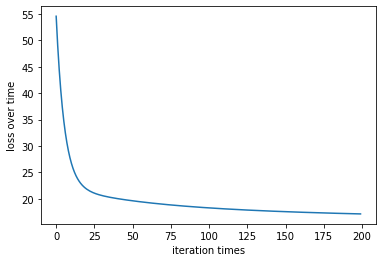

Final loss on model: 
17.146486


In [ ]:
train_epochs(model, epochs=200, learning_rate=10)

In [ ]:
# The empty places in the matrix (The prediction of ratings for the users that we don't know)
testloss(model) 

tensor([ 3725, 11245, 19629, 18426,  3408, 18780,   686,  6669,  6226])


tensor([ -0.7834,  -0.7288,   9.2673,   2.7147, -10.0084,  -5.0514,  -4.8265,
          0.2679,  -0.1710], grad_fn=<SumBackward1>)

#Variational AutoEncoder Model Creation

For creating a Variational AutoEncoder Model we first define the encoder and decoder networks as PyTorch modules. The encoder network maps the input data to a lower-dimensional latent space and the decoder network maps the latent space back to the original data space.
A VAE loss function has also to be defined. It consists of a reconstruction loss and a regularization loss. The reconstruction loss measures the difference between the input data and the decoder output using the MSELoss function from PyTorch. The regularization loss measures the difference between the encoder output (latent space) and the prior distribution. The function returns the sum of both measures.
We train the VAE model by iterating over the data, passing it through the encoder and decoder networks, computing the loss, and updating the model parameters. 

**QUITAR?** An optimizer is used to minimize the VAE loss function by adjusting the model parameters. The optimizer used Adam and the function is the zero gradient


In [ ]:
# Defining the Encoder
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, emb_size):
    super(Encoder, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, emb_size)
      
  def forward(self, x):
    x = x.to(torch.float32)
    x = torch.relu(self.l1(x))
    x = self.l2(x)
    return x

In [ ]:
# Defining the Decoder
class Decoder(nn.Module):
  def __init__(self, emb_size, hidden_size, output_size):
    super(Decoder, self).__init__()
    self.l1 = nn.Linear(emb_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = x.to(torch.float32)
    x = torch.relu(self.l1(x))
    x = self.l2(x)
    return x

In [ ]:
# The VAE model
class VAE(nn.Module):
  def __init__(self, encoder, decoder):
    super(VAE, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
# Training the model
def train_model_vae(vae, data, epochs):
  optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
  d = torch.clone(torch.LongTensor(data.values.astype(float))) # Make a clone of the train dataset for the loss function 
  data = torch.LongTensor(data.values.astype(float)) #convert dataframe to tensor
  for i in range(epochs):
    vae.train()
    '''mu = vae.encoder(data)
    y_hat = vae.decoder(mu)'''
    y_hat = vae(data)

    loss = loss_fn(y_hat.to(torch.float32) , d.to(torch.float32))
    val_loss = validate_model_vae(vae, validation)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
    print(i ,': train loss %f valid loss %f'%(loss.item(), val_loss))
    print('----------------------------------')

In [ ]:
# Validation Data
def validate_model_vae(vae, data):
  vae.eval()
  data = torch.LongTensor(data.values.astype(float)) #convert dataframe to tensor
  y_hat = vae(data)
  val_loss = F.mse_loss(data.to(torch.float32), y_hat.to(torch.float32))
  return val_loss.item()

In [ ]:
# Testing the model
def test_model_vae(vae,data):
  vae.eval()
  data = torch.LongTensor(data.values.astype(float)) #convert dataframe to tensor
  y_hat = vae(data)
  print('Predicted Data: ')
  print(y_hat)

In [ ]:
# Prepare model parameters
data_len = len(train.user_id)
# Drop the timestamp column we do not need
train.drop(columns=['timestamp'], inplace=True)
validation.drop(columns=['timestamp'], inplace=True)
q_df.drop(columns=['timestamp'], inplace=True)
# Define the range of embedding sizes to test
emb_size = 64
# Define the number of epochs, number of times to go over the model
num_epochs = 10 

In [ ]:
# Creating the encoder, decoder and the model
encoder = Encoder(3, data_len, emb_size)
decoder = Decoder(emb_size, data_len, 3)
vae = VAE(encoder, decoder)

In [ ]:
train_model_vae(vae, train,epochs=num_epochs)

0 : train loss 48016820.000000 valid loss 50072088.000000
----------------------------------
1 : train loss 12784398336.000000 valid loss 13331309568.000000
----------------------------------
2 : train loss 5864778240.000000 valid loss 6115885568.000000
----------------------------------
3 : train loss 485178368.000000 valid loss 505918176.000000
----------------------------------
4 : train loss 875082880.000000 valid loss 912475840.000000
----------------------------------
5 : train loss 3101326080.000000 valid loss 3234131456.000000
----------------------------------
6 : train loss 320251872.000000 valid loss 333946176.000000
----------------------------------
7 : train loss 2378072320.000000 valid loss 2479779840.000000
----------------------------------
8 : train loss 705047488.000000 valid loss 735267392.000000
----------------------------------
9 : train loss 1635579264.000000 valid loss 1705627392.000000
----------------------------------
